<a href="https://colab.research.google.com/github/SubhraSMukherjee/Soft_Segmentation/blob/main/Kohonen_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Segmenting & Visualizing Countries by using Soft Segmentation Techniques for HELP International

>**Objective:**
To categorise the countries using socio-economic and health factors that determine the overall development of the country.

>**About organization:** HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities

>**Problem Statement:** HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

[[Data Source]](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data)
*Unsupervised Learning on Country Macro Economic Data*

In [2]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=abf94527a43e1457d6b61ce20fc29af7efe0994ad684782a246770b0f4dc80c2
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


In [4]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

>### Import worksheet from Gdrive

In [5]:
import gspread
from google.auth import default
from google.colab import auth
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_key('1bVE11CQZ7dlfr-nwxMHuNzh3x0VYpM28-8DCODGCmDE')
worksheet = spreadsheet.get_worksheet(0)
df = pd.DataFrame(worksheet.get()).convert_dtypes()
df.columns = df.iloc[0]
df = df.drop(0)
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
1,Afghanistan,90.2,10,7.58,44.9,1610,9.44,56.2,5.82,553
2,Albania,16.6,28,6.55,48.6,9930,4.49,76.3,1.65,4090
3,Algeria,27.3,38.4,4.17,31.4,12900,16.1,76.5,2.89,4460
4,Angola,119,62.3,2.85,42.9,5900,22.4,60.1,6.16,3530
5,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


>### Data Dictonary
---

In [ ]:
Data_Dictonary = pd.DataFrame(spreadsheet.get_worksheet(1).get()).convert_dtypes()
Data_Dictonary.columns = Data_Dictonary.iloc[0]
Data_Dictonary = Data_Dictonary.drop(0)
Data_Dictonary

,Column Name,Description
1,country,Name of the country
2,child_mort,Death of children under 5 years of age per 100...
3,exports,Exports of goods and services per capita. Give...
4,health,Total health spending per capita. Given as %ag...
5,imports,Imports of goods and services per capita. Give...
6,Income,Net income per person
7,Inflation,The measurement of the annual growth rate of t...
8,life_expec,The average number of years a new born child w...
9,total_fer,The number of children that would be born to e...
10,gdpp,The GDP per capita. Calculated as the Total GD...


In [ ]:
columns_ordinal = []
for column in df.columns:
  if column != 'country':
    df[column] = df[column].astype(float)
    df[column] = (df[column] - df[column].mean(axis=0)) / (df[column].std(axis=0))  #standardize
    columns_ordinal.append(column)

> ### Kohonen Maps (Self Organizing Maps)

>>  ### Implementing a Kohonen Map with a 10x10 Hexagonal Topology
> [Kohonen Maps](https://www.geeksforgeeks.org/python/self-organising-maps-kohonen-maps/)
are an Neural Network based unsupervised algorithm that preserves the topological structure of the data. Loosely speaking, it means that we can **'see'** the difference between the types of data elements with the most similar ones clubbed together and the different ones further apart

In [ ]:
som = MiniSom(
    x=10, y=10, input_len=len(columns_ordinal),
    sigma=1, learning_rate=0.5,
    neighborhood_function='gaussian',
    topology='hexagonal',
    random_seed=42
)


som.train_random(df[columns_ordinal].to_numpy(), 10000)

In [ ]:
u_matrix = som.distance_map()
mapped = np.array([som.winner(x) for x in df[columns_ordinal].to_numpy()])
mapped_x = [m[0] + (0.5 * (m[1] % 2)) for m in mapped]  # offset x for hex layout
mapped_y = [np.sqrt(3)/2 * m[1] for m in mapped]        # offset y for hex layout

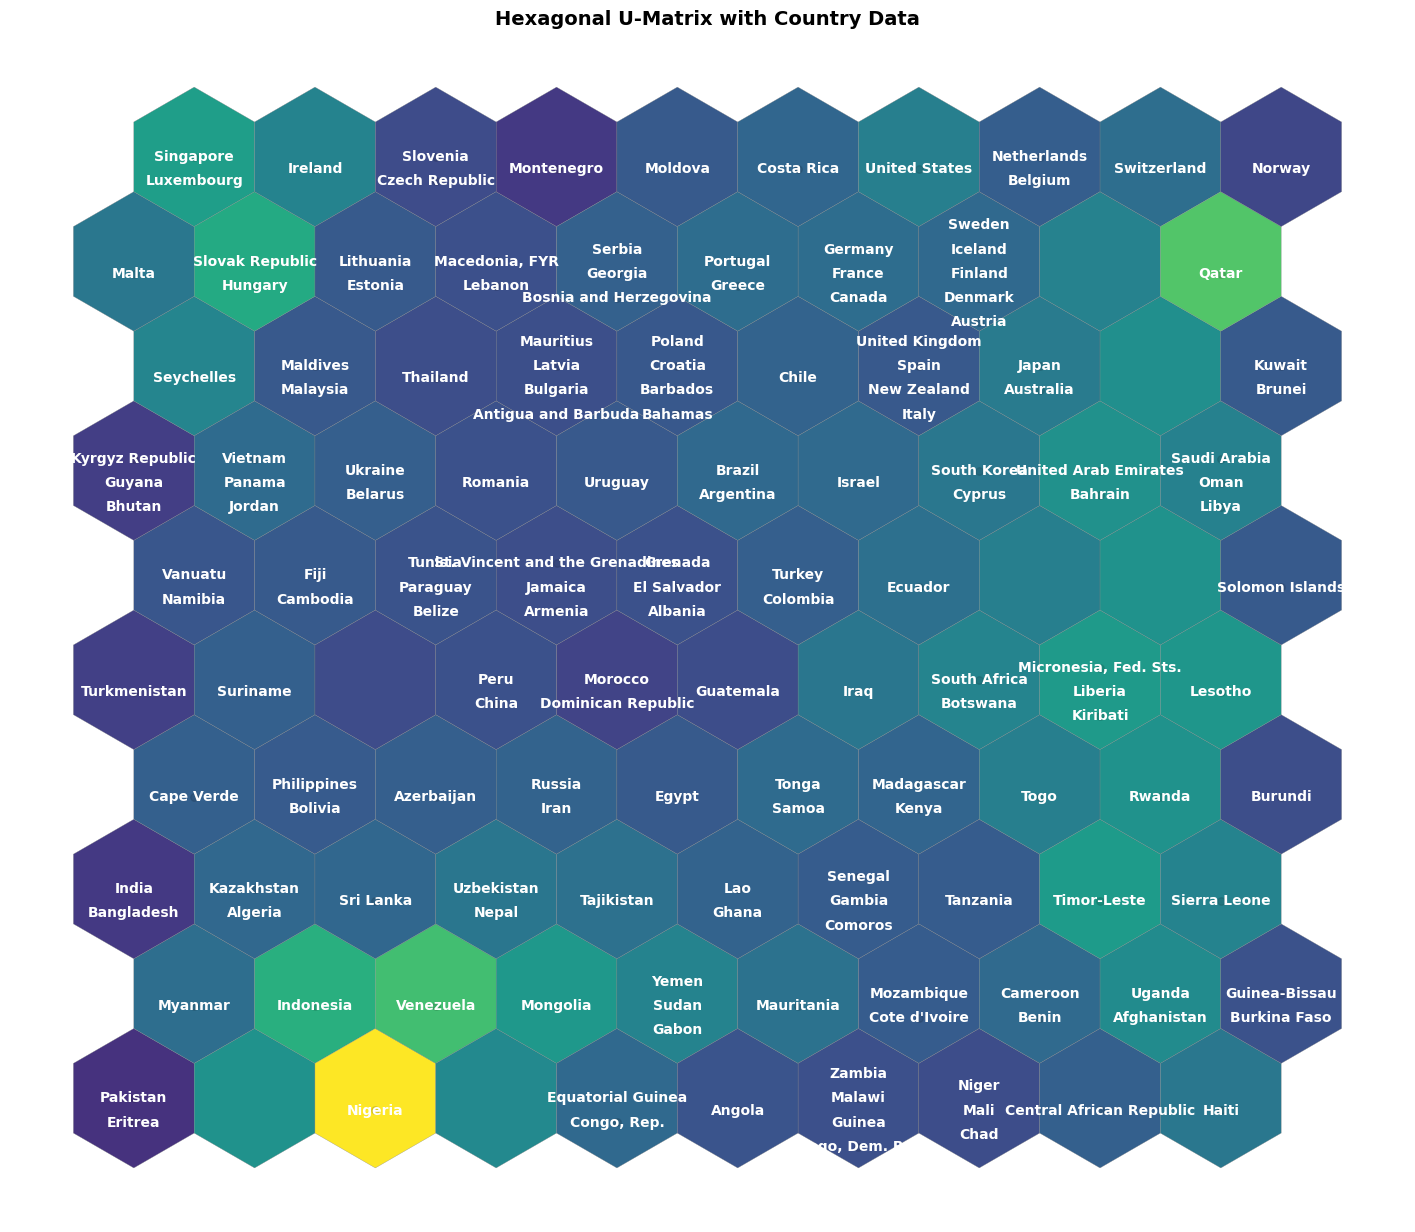

In [ ]:
from collections import defaultdict

fig, ax = plt.subplots(figsize=(18, 18))
ax.set_aspect('equal')
ax.set_title("Hexagonal U-Matrix with Country Data", fontsize=14, weight='bold')

hex_radius = 1 / np.sqrt(3)
# Draw hexagonal grid
m, n = som.get_weights().shape[:2]
for i in range(m):
    for j in range(n):
        x = i + (0.5 * (j % 2))          # offset every other row
        y = np.sqrt(3)/2 * j
        color = plt.cm.viridis(u_matrix[i, j])  # color by U-Matrix value
        hex_cell = RegularPolygon(
            (x, y),
            numVertices=6,
            radius=hex_radius,
            facecolor=color,
            edgecolor='gray',
            linewidth=0.2
        )
        ax.add_patch(hex_cell)

bmu_labels = defaultdict(list)
for (coord, label) in zip(mapped, list(df['country'].values)):
    bmu_labels[tuple(coord)].append(label)

for (i, j), lbls in bmu_labels.items():
    x = i + (0.5 * (j % 2))
    y = np.sqrt(3)/2 * j
    for k, label in enumerate(lbls):
        y_offset = y + (0.2 * (k - len(lbls)/2))
        ax.scatter(x, y_offset, s=30, c='black', alpha=0.1)
        ax.text(x, y_offset, label, color='white', fontsize=10,
                ha='center', va='center', weight='bold')

plt.axis('off')
plt.show()

___

### Fuzzy C Means

>>  ### Estimating the number of Convex Cluster Centroids
> The [Calinski–Harabasz Index](https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index) (also called the Variance Ratio Criterion) is a metric used to evaluate clustering quality/number of Clusters. I use it here because unlike some of the other Cluster Validity Indices (e.g., Dunn Index) it is computationally less expensive. It however works best when clusters are convex

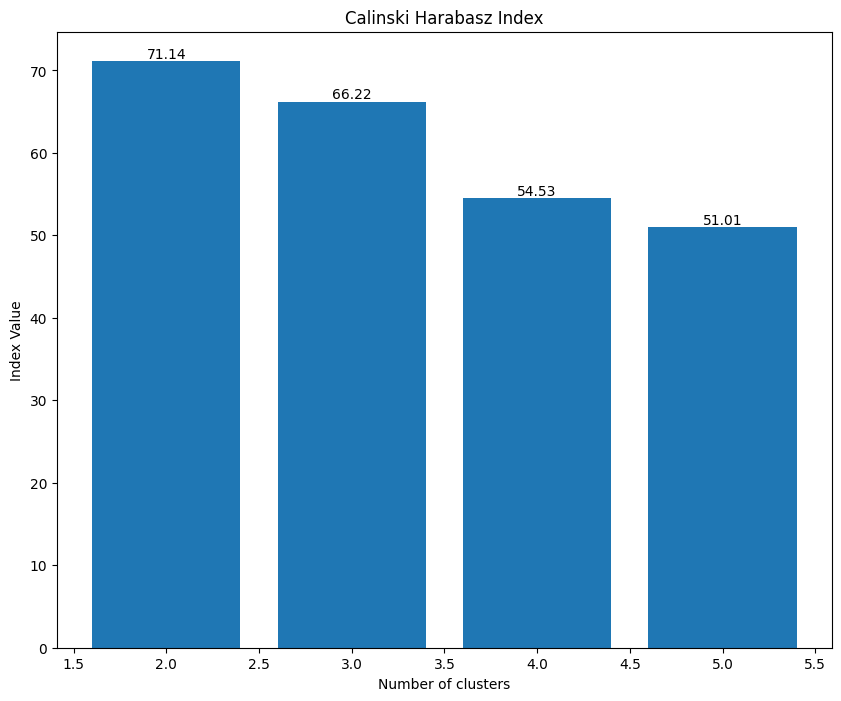

In [22]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

columns_ordinal = []
for column in df.columns:
  if column != 'country':
    df[column] = df[column].astype(float)
    columns_ordinal.append(column)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[columns_ordinal])

CH_Index = {}
for i in range(2,6):
  kmeans = KMeans(n_clusters=i, random_state = 46).fit(data_scaled)
  score = calinski_harabasz_score(data_scaled, kmeans.labels_)
  CH_Index[i] = score

fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(CH_Index.keys(), list(CH_Index.values()))
for cluster in CH_Index:
    plt.text(cluster, CH_Index[cluster], str(round(CH_Index[cluster],2)), ha='center', va='bottom')

plt.title('Calinski Harabasz Index')
plt.xlabel('Number of clusters')
plt.ylabel('Index Value')
plt.show()

>### Dunn Index

Using Dunn index since CH score doesnt clearly seperate clusters

\
\begin{aligned}
\text{DI} &=
\frac{
    \displaystyle \min_{i \neq j} d(C_i, C_j)
}{
    \displaystyle \max_k \operatorname{diam}(C_k)
}
\\[6pt]
\text{where}\quad
\operatorname{diam}(C_k) &=
\max_{x,\, y \in C_k} d(x, y)
\end{aligned}

In [7]:
from scipy.spatial.distance import cdist

def dunn_index(X, labels):
    unique_clusters = np.unique(labels)

    diameters = []
    for c in unique_clusters:
        points = X[labels == c]
        if len(points) > 1:
            diam = np.max(cdist(points, points))
        else:
            diam = 0
        diameters.append(diam)

    max_diameter = np.max(diameters)


    inter_cluster_distances = []
    for i in unique_clusters:
        for j in unique_clusters:
            if i < j:
                Ci = X[labels == i]
                Cj = X[labels == j]
                dist = np.min(cdist(Ci, Cj))
                inter_cluster_distances.append(dist)

    min_intercluster = np.min(inter_cluster_distances)

    return min_intercluster / max_diameter

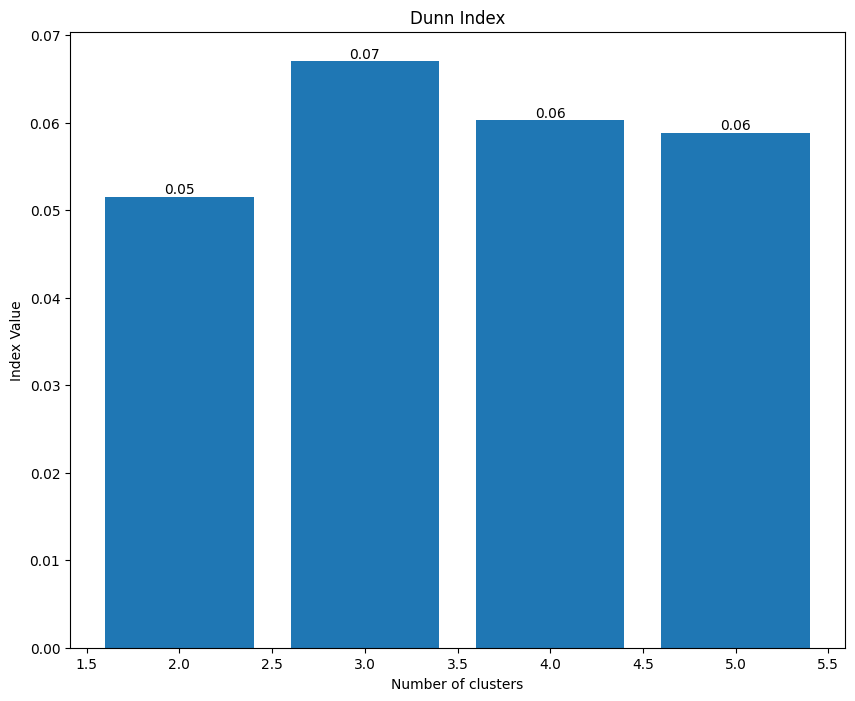

In [19]:
Dunn_Index = {}
for i in range(2,6):
  kmeans = KMeans(n_clusters=i, random_state = 43).fit(data_scaled)
  score = dunn_index(data_scaled, kmeans.labels_)
  Dunn_Index[i] = score


fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(Dunn_Index.keys(), list(Dunn_Index.values()))
for cluster in CH_Index:
    plt.text(cluster, Dunn_Index[cluster], str(round(Dunn_Index[cluster],2)), ha='center', va='bottom')

plt.title('Dunn Index')
plt.xlabel('Number of clusters')
plt.ylabel('Index Value')
plt.show()

> ### 3 clusters seem to be the Optimal here using both the Calinski–Harabasz & the Dunn Index

In [28]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.5 MB/s eta 0:00:00


> ### Final Fuzzy Clusters colored by an RGB scheme

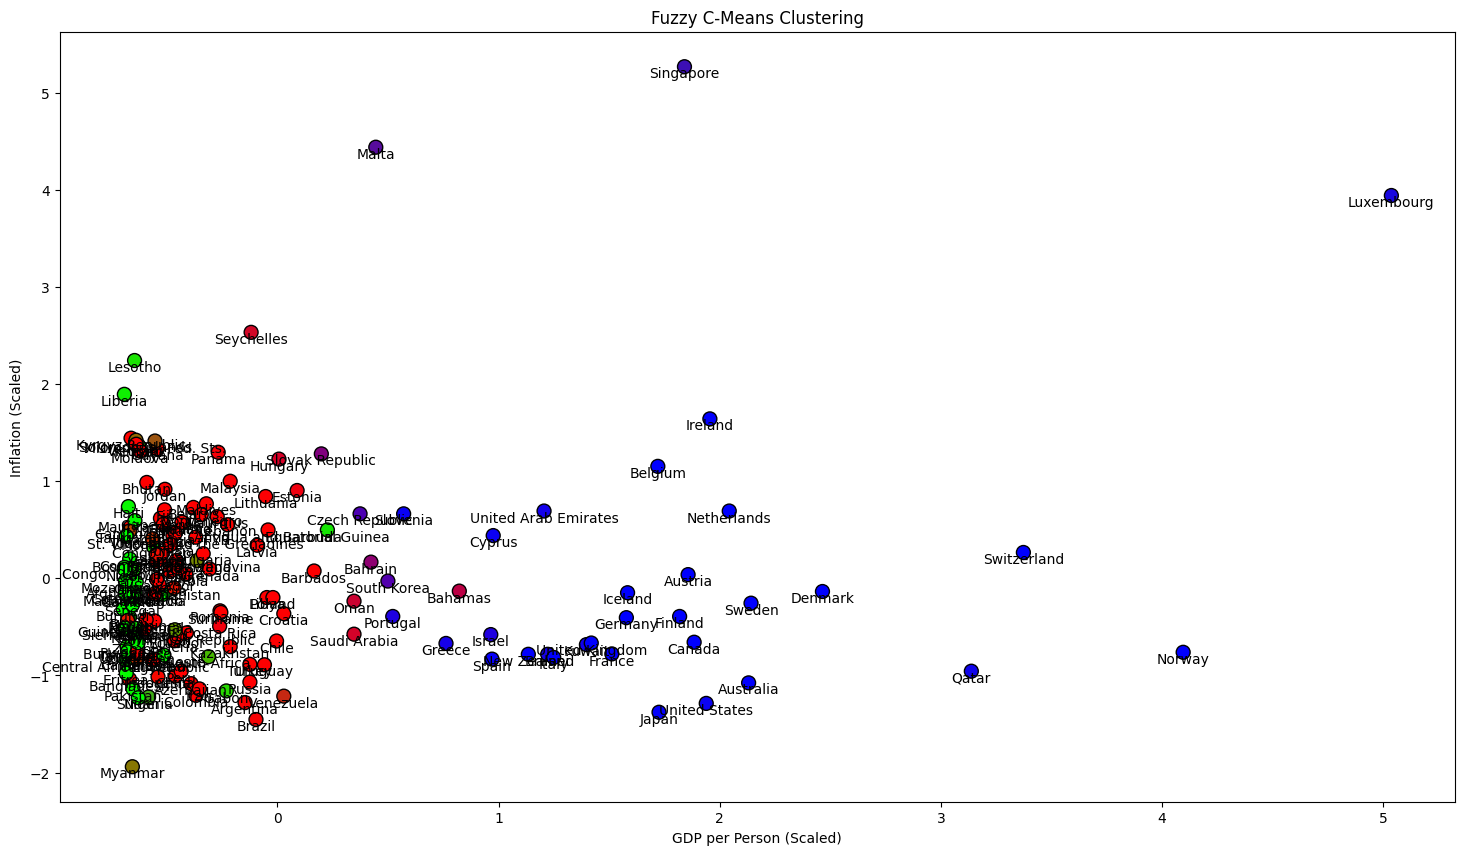

In [33]:
import skfuzzy as fuzz


X_T = data_scaled.T
c = 3
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_T, c=c, m=1.23, error=1e-5, maxiter=10000, init=None
)


colors = np.zeros((X_T.shape[1], 3))
colors[:, 0] = u[0]
colors[:, 1] = u[1]  # Red channel = membership of cluster 0
colors[:, 2] = u[2]

fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(data_scaled[:,8], data_scaled[:,3], color=colors, s=100, edgecolors='k')
# Plot cluster centers
#plt.scatter(cntr[:, 0], cntr[:, 1], marker='X', s=300, c='red')

for i, term in enumerate(df['country'].tolist()):
    ax.text(data_scaled[:,8].tolist()[i], data_scaled[:,3].tolist()[i], term, verticalalignment ='top',
        horizontalalignment ='center')


plt.title("Fuzzy C-Means Clustering")
plt.xlabel("GDP per Person (Scaled)")
plt.ylabel("Inflation (Scaled)")
#plt.grid(True)
plt.show()